## Random sampling periodic review

In [ ]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import operator
import timeit
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import seaborn as sns
from joblib import Parallel, delayed

In [ ]:
start = timeit.default_timer()

summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],  
    'Co': [1000, 1200, 1000, 1200],  
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Demand_lead': [705, 3891, 2266, 785]
}

demand = {
    'Pr1': [28670],
    'Pr2': [237370],
    'Pr3': [51831],
    'Pr4': [13056]
}

class Product:
    def __init__(self, i):
        """
        :type i: int - Product number
        """
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.demand_lead = summary['Demand_lead'][i - 1]

        self.mean = np.mean([np.log(j) for j in demand[f'Pr{i}'] if j > 0])
        self.sd = np.std([np.log(j) for j in demand[f'Pr{i}'] if j > 0])

def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0, 1)
    if random_num > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS(Q, product, review_period=30, z_score=1.65):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.demand_lead

    safety_stock = (mean + sd * z_score) * lead_time

    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if day % review_period == 0:
            # Placing the order
            q = max(0, safety_stock - inventory + demand_lead)
            q = max(q, int(0.2 * mean))  
            q = min(q, inventory)  
            order_placed = True
            data['orders'].append(q)

        if order_placed:
            counter += 1

        if counter == lead_time:
            # Restocking day
            inventory += q
            order_placed = False
            counter = 0

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        else:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    return data

def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size * (1 / days)
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

def simulation(product, Q, num_simulations=1000, z_score=1.65):
    profit_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = MCS(Q, product, z_score=z_score)
        # Calculating the profit
        profit = profit_calculation(data, product)
        profit_list.append(profit)
        # Calculating the orders lost
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders / total_demand)

    return profit_list, orders_lost_list

def monte_carlo_random_sampling(product, low, high, step=50, num_samples=1000, min_order_quantity=0, 
                                max_order_quantity=np.inf, z_score=1.65):
    sampled_M_values = np.random.uniform(low, high, num_samples)

    review_dict = {}

    for M in sampled_M_values:
        M = int(M)  

        # constraints
        if M < min_order_quantity or M > max_order_quantity:
            continue

        # Monte Carlo simulation for each sampled M value
        p_list, o_list = simulation(product, Q, num_simulations=NUM_SIMULATIONS, z_score=z_score)
        review_dict[Q] = (np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), 
                          np.std(p_list), np.mean(o_list))

    return review_dict

def periodic_review(product, low, high, step=50, num_samples=10, min_order_quantity=0, 
                    max_order_quantity=np.inf, z_score=1.65):
    mean = (low + high) / 2
    std_dev = (high - low) / 6  # Assuming 99.7% of values within range for normal distribution

    q_range_random = np.random.normal(mean, std_dev, num_samples)  
    q_range_random = np.clip(q_range_random, low, high)  

    review_dict = {}

    print(f"Product {product.i} - Min Order Quantity: {min_order_quantity}, Max Order Quantity: {max_order_quantity}")

    for Q in q_range_random:
        Q = int(Q)  
        print(f"Testing Q value: {Q}")

        # Apply constraints
        if Q < min_order_quantity or Q > max_order_quantity:
            print(f"Q value {Q} out of constraints")
            continue

        p_list, o_list = simulation(product, Q, num_simulations=NUM_SIMULATIONS, z_score=z_score)
        review_dict[Q] = (np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), 
                          np.std(p_list), np.mean(o_list))

    return review_dict

# constraints
MIN_ORDER_QUANTITY_PERCENTAGE = 0.2  
MAX_ORDER_QUANTITY_PERCENTAGE = 0.5  
NUM_SIMULATIONS = 1000  

# average demand for each product
average_demand = {f'Pr{i+1}': np.mean(demand[f'Pr{i+1}']) for i in range(len(summary['Purchase Cost']))}

# maximum order quantities based on the percentages
max_order_quantities = {f'Pr{i+1}': int(average_demand[f'Pr{i+1}'] * MAX_ORDER_QUANTITY_PERCENTAGE) for i in range(len(summary['Purchase Cost']))}


# random sampling and periodic review for each product with the constraints
prod_reviews_random_sampling = {}
for i in range(1, 5):
    min_order_quantity = int(average_demand[f'Pr{i}'] * MIN_ORDER_QUANTITY_PERCENTAGE)
    max_order_quantity = max_order_quantities[f'Pr{i}']

    # min and max order quantities
    low = min_order_quantity
    high = max_order_quantity

    review_random_sampling = periodic_review(Product(i), low=low, high=high, min_order_quantity=min_order_quantity, 
                                             max_order_quantity=max_order_quantity, num_samples=NUM_SIMULATIONS)
    prod_reviews_random_sampling[f'Product {i}'] = review_random_sampling

# print(prod_reviews_random_sampling)

best_Q_values = {}

for product, review_dict in prod_reviews_random_sampling.items():
    best_Q = max(review_dict, key=lambda key: review_dict[key][0])  
    best_stats = review_dict[best_Q]
    best_M_values[product] = (best_Q, best_stats)

print(best_Q_values)

stop = timeit.default_timer()
print('Time: ', stop - start)



Product 1 - Min Order Quantity: 5734, Max Order Quantity: 14335
Testing Q value: 8524
Testing Q value: 8503
Testing Q value: 11396
Testing Q value: 12486
Testing Q value: 9884
Testing Q value: 9792
Testing Q value: 10134
Testing Q value: 11700
Testing Q value: 8705
Testing Q value: 10376
Testing Q value: 11432
Testing Q value: 10752
Testing Q value: 10306
Testing Q value: 11469
Testing Q value: 6159
Testing Q value: 11006
Testing Q value: 9096
Testing Q value: 7410
Testing Q value: 10767
Testing Q value: 12003
Testing Q value: 9837
Testing Q value: 11400
Testing Q value: 12345
Testing Q value: 11919
Testing Q value: 12385
Testing Q value: 11098
Testing Q value: 10142
Testing Q value: 7738
Testing Q value: 9681
Testing Q value: 8825
Testing Q value: 13146
Testing Q value: 9782
Testing Q value: 10211
Testing Q value: 10825
Testing Q value: 10097
Testing Q value: 12464
Testing Q value: 9141
Testing Q value: 10313
Testing Q value: 8970
Testing Q value: 8142
Testing Q value: 9157
Testing Q 

In [8]:
best_Q_values = {}
for product, review_dict in prod_reviews_random_sampling.items():
    best_Q = max(review_dict, key=lambda key: review_dict[key][0])  # Find M with highest mean profit
    best_stats = review_dict[best_Q]
    best_Q_values[product] = (best_Q, best_stats)
best_Q_values

{'Product 1': (9999,
  (32272.36144657535,
   32264.69315068494,
   32275.000000000007,
   6.0316118980803255,
   0.9996522725767731)),
 'Product 2': (74606, (179100.0, 179100.0, 179100.0, 0.0, 0.9997395914108224)),
 'Product 3': (12754,
  (41036.84683397259,
   41021.87835616438,
   41039.99999999999,
   6.270298262396244,
   0.9996062874980536)),
 'Product 4': (4959,
  (80710.38316164384,
   80501.97260273973,
   80800.0,
   101.33348298358025,
   0.9987097936256312))}

## Importance sampling perodic review

In [92]:
np.random.seed(42)

start = timeit.default_timer()

summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Demand_lead': [705, 3891, 2266, 785]
}

demand = {
    'Pr1': [28670],
    'Pr2': [237370],
    'Pr3': [51831],
    'Pr4': [13056]
}

class Product:
    def __init__(self, i):
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.demand_lead = summary['Demand_lead'][i - 1]
        self.mean = np.mean([np.log(j) for j in demand[f'Pr{i}'] if j > 0])
        self.sd = np.std([np.log(j) for j in demand[f'Pr{i}'] if j > 0])
        self.max_daily_sales = max(demand[f'Pr{i}'])
        self.avg_daily_sales = np.mean(demand[f'Pr{i}'])

def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0, 1)
    if random_num > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS(Q, product, review_period=30):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    max_daily_sales = product.max_daily_sales
    avg_daily_sales = product.avg_daily_sales

    safety_stock = (max_daily_sales * lead_time) - (avg_daily_sales * lead_time)

    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if day % review_period == 0:
            q = max(0, safety_stock - inventory + product.demand_lead)
            q = max(q, int(0.2 * mean))
            q = min(q, inventory)
            q = min(q, int(0.5 * mean))
            order_placed = True
            data['orders'].append(q)

        if order_placed:
            counter += 1

        if counter == lead_time:
            inventory += q
            order_placed = False
            counter = 0

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        else:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

        if sum(data['daily_demand'][-lead_time:]) > safety_stock:
            print("Warning: Demand during lead time exceeds safety stock.")

        if inventory < 0:
            print("Warning: Inventory level is insufficient to meet demand.")

    return data

def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size * (1 / days)
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

def generate_importance_samples(product, num_samples=1000):
    mean_demand = product.mean
    std_demand = product.sd
    probability = product.probability

    lognormal_samples = np.random.lognormal(mean=np.log(mean_demand), sigma=std_demand, size=num_samples)
    lognormal_samples = np.clip(lognormal_samples, 1e-6, None)

    if np.isclose(std_demand, 0):  
        weights = np.ones_like(lognormal_samples) / len(lognormal_samples)
    else:
        log_weights = np.zeros_like(lognormal_samples)
        non_zero_indices = lognormal_samples != 0

        log_weights[non_zero_indices] = -np.log(lognormal_samples[non_zero_indices]) - 0.5 * ((np.log(lognormal_samples[non_zero_indices]) - np.log(mean_demand)) / std_demand)**2
        log_weights[~non_zero_indices] = -np.inf  

        max_log_weight = np.max(log_weights)
        weights = np.exp(log_weights - max_log_weight)
        weights /= np.sum(weights)

    # Debugging information
    print("Mean of lognormal_samples:", np.mean(lognormal_samples))
    print("Std deviation of lognormal_samples:", np.std(lognormal_samples))
    print("Max of lognormal_samples:", np.max(lognormal_samples))
    print("Mean of weights:", np.mean(weights))
    print("Std deviation of weights:", np.std(weights))
    print("Sum of weights:", np.sum(weights))

    return lognormal_samples, weights


def mc_simulation_with_importance_sampling(product, Q, num_samples=10000):
    samples, weights = generate_importance_samples(product, num_samples)
    sampled_indices = np.random.choice(len(samples), size=num_samples, replace=True, p=weights)
    sampled_samples = samples[sampled_indices]

    results = Parallel(n_jobs=-1)(delayed(MCS)(Q, product, demand) for demand in sampled_samples)

    profit_list = []
    orders_lost_list = []

    for data in results:
        profit = profit_calculation(data, product)
        profit_list.append(profit)
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders / total_demand if total_demand > 0 else 0)

    return profit_list, orders_lost_list

def periodic_review(product, low, high, step=50, num_samples=10, min_order_quantity=0, max_order_quantity=np.inf):
    mean = (low + high) / 2
    std_dev = (high - low) / 6

    q_range_is = np.random.normal(mean, std_dev, num_samples)
    q_range_is = np.clip(q_range_is, low, high)

    review_dict = {}

    for Q in q_range_is:
        Q = int(Q)
        print(f"Testing Q value: {Q}")

        if Q < min_order_quantity or Q > max_order_quantity:
            print(f"Q value {Q} out of constraints")
            continue

        p_list, o_list = mc_simulation_with_importance_sampling(product, Q, num_samples=num_samples)
        review_dict[M] = (np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))

    return review_dict

MIN_ORDER_QUANTITY_PERCENTAGE = 0.2
MAX_ORDER_QUANTITY_PERCENTAGE = 0.5

average_demand = {f'Pr{i+1}': np.mean(demand[f'Pr{i+1}']) for i in range(len(summary['Purchase Cost']))}
max_order_quantities = {f'Pr{i+1}': int(average_demand[f'Pr{i+1}'] * MAX_ORDER_QUANTITY_PERCENTAGE) for i in range(len(summary['Purchase Cost']))}

prod_reviews = {}
for i in range(1, 5):
    min_order_quantity = int(average_demand[f'Pr{i}'] * MIN_ORDER_QUANTITY_PERCENTAGE)
    max_order_quantity = max_order_quantities[f'Pr{i}']
    low = min_order_quantity
    high = max_order_quantity
    review = periodic_review(Product(i), low=low, high=high, min_order_quantity=min_order_quantity, max_order_quantity=max_order_quantity)
    prod_reviews[f'Product {i}'] = review

best_M_values = {}

for product, review_dict in prod_reviews.items():
    best_Q = max(review_dict, key=lambda key: review_dict[key][0])  # Find M with highest mean profit
    best_stats = review_dict[best_Q]
    best_Q_values[product] = (best_Q, best_stats)

print(best_Q_values)

stop = timeit.default_timer()
print('Time: ', stop - start)


Testing M value: 10746
Mean of lognormal_samples: 10.263606558877413
Std deviation of lognormal_samples: 0.0
Max of lognormal_samples: 10.263606558877413
Mean of weights: 0.1
Std deviation of weights: 0.0
Sum of weights: 1.0
Testing M value: 9836
Mean of lognormal_samples: 10.263606558877413
Std deviation of lognormal_samples: 0.0
Max of lognormal_samples: 10.263606558877413
Mean of weights: 0.1
Std deviation of weights: 0.0
Sum of weights: 1.0
Testing M value: 10962
Mean of lognormal_samples: 10.263606558877413
Std deviation of lognormal_samples: 0.0
Max of lognormal_samples: 10.263606558877413
Mean of weights: 0.1
Std deviation of weights: 0.0
Sum of weights: 1.0
Testing M value: 12217
Mean of lognormal_samples: 10.263606558877413
Std deviation of lognormal_samples: 0.0
Max of lognormal_samples: 10.263606558877413
Mean of weights: 0.1
Std deviation of weights: 0.0
Sum of weights: 1.0
Testing M value: 9698
Mean of lognormal_samples: 10.263606558877413
Std deviation of lognormal_sample

## Importance sampling using satistical method of calculating safety stock
- safety_stock = (mean + sd * 1.65) * lead_time

In [93]:
np.random.seed(42)

start = timeit.default_timer()

summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Demand_lead': [705, 3891, 2266, 785]
}

demand = {
    'Pr1': [28670],
    'Pr2': [237370],
    'Pr3': [51831],
    'Pr4': [13056]
}

class Product:
    def __init__(self, i):
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.demand_lead = summary['Demand_lead'][i - 1]
        self.mean = np.mean([np.log(j) for j in demand[f'Pr{i}'] if j > 0])
        self.sd = np.std([np.log(j) for j in demand[f'Pr{i}'] if j > 0])
        self.max_daily_sales = max(demand[f'Pr{i}'])
        self.avg_daily_sales = np.mean(demand[f'Pr{i}'])

def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0, 1)
    if random_num > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS(Q, product, review_period=30):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    max_daily_sales = product.max_daily_sales
    avg_daily_sales = product.avg_daily_sales

    safety_stock = (mean + sd * 1.65) * lead_time  

    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if day % review_period == 0:
            q = max(0, safety_stock - inventory + product.demand_lead)
            q = max(q, int(0.2 * mean))
            q = min(q, inventory)
            q = min(q, int(0.5 * mean))
            order_placed = True
            data['orders'].append(q)

        if order_placed:
            counter += 1

        if counter == lead_time:
            inventory += q
            order_placed = False
            counter = 0

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        else:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

        if sum(data['daily_demand'][-lead_time:]) > safety_stock:
            print("Warning: Demand during lead time exceeds safety stock.")

        if inventory < 0:
            print("Warning: Inventory level is insufficient to meet demand.")

    return data

def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size * (1 / days)
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

def generate_importance_samples(product, num_samples=1000):
    mean_demand = product.mean
    std_demand = product.sd
    probability = product.probability

    lognormal_samples = np.random.lognormal(mean=np.log(mean_demand), sigma=std_demand, size=num_samples)
    lognormal_samples = np.clip(lognormal_samples, 1e-6, None)

    if np.isclose(std_demand, 0):  
        weights = np.ones_like(lognormal_samples) / len(lognormal_samples)
    else:
        log_weights = np.zeros_like(lognormal_samples)
        non_zero_indices = lognormal_samples != 0

        log_weights[non_zero_indices] = -np.log(lognormal_samples[non_zero_indices]) - 0.5 * ((np.log(lognormal_samples[non_zero_indices]) - np.log(mean_demand)) / std_demand)**2
        log_weights[~non_zero_indices] = -np.inf  

        max_log_weight = np.max(log_weights)
        weights = np.exp(log_weights - max_log_weight)
        weights /= np.sum(weights)

    # Debugging information
    print("Mean of lognormal_samples:", np.mean(lognormal_samples))
    print("Std deviation of lognormal_samples:", np.std(lognormal_samples))
    print("Max of lognormal_samples:", np.max(lognormal_samples))
    print("Mean of weights:", np.mean(weights))
    print("Std deviation of weights:", np.std(weights))
    print("Sum of weights:", np.sum(weights))

    return lognormal_samples, weights


def mc_simulation_with_importance_sampling(product, Q, num_samples=10000):
    samples, weights = generate_importance_samples(product, num_samples)
    sampled_indices = np.random.choice(len(samples), size=num_samples, replace=True, p=weights)
    sampled_samples = samples[sampled_indices]

    results = Parallel(n_jobs=-1)(delayed(MCS)(Q, product) for _ in range(num_samples))

    profit_list = []
    orders_lost_list = []

    for data in results:
        profit = profit_calculation(data, product)
        profit_list.append(profit)
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders / total_demand if total_demand > 0 else 0)

    return profit_list, orders_lost_list

def periodic_review(product, low, high, step=50, num_samples=10, min_order_quantity=0, max_order_quantity=np.inf):
    mean = (low + high) / 2
    std_dev = (high - low) / 6

    m_range_is = np.random.normal(mean, std_dev, num_samples)
    m_range_is = np.clip(m_range_is, low, high)

    review_dict = {}

    for Q in q_range_is:
        Q = int(Q)

        if Q < min_order_quantity or Q > max_order_quantity:
            continue

        p_list, o_list = mc_simulation_with_importance_sampling(product, Q, num_samples=num_samples)
        review_dict[M] = (np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), 
                          np.std(p_list), np.mean(o_list))

    return review_dict

MIN_ORDER_QUANTITY_PERCENTAGE = 0.2
MAX_ORDER_QUANTITY_PERCENTAGE = 0.5

average_demand = {f'Pr{i+1}': np.mean(demand[f'Pr{i+1}']) for i in range(len(summary['Purchase Cost']))}
max_order_quantities = {f'Pr{i+1}': int(average_demand[f'Pr{i+1}'] * MAX_ORDER_QUANTITY_PERCENTAGE) for i in range(len(summary['Purchase Cost']))}

prod_reviews = {}
for i in range(1, 5):
    min_order_quantity = int(average_demand[f'Pr{i}'] * MIN_ORDER_QUANTITY_PERCENTAGE)
    max_order_quantity = max_order_quantities[f'Pr{i}']
    low = min_order_quantity
    high = max_order_quantity
    review = periodic_review(Product(i), low=low, high=high, min_order_quantity=min_order_quantity, max_order_quantity=max_order_quantity)
    prod_reviews[f'Product {i}'] = review

best_M_values = {}

for product, review_dict in prod_reviews.items():
    best_Q = max(review_dict, key=lambda key: review_dict[key][0])  
    best_stats = review_dict[best_Q]
    best_Q_values[product] = (best_Q, best_stats)

print(best_Q_values)

stop = timeit.default_timer()
print('Time: ', stop - start)


Mean of lognormal_samples: 10.263606558877413
Std deviation of lognormal_samples: 0.0
Max of lognormal_samples: 10.263606558877413
Mean of weights: 0.1
Std deviation of weights: 0.0
Sum of weights: 1.0
Mean of lognormal_samples: 10.263606558877413
Std deviation of lognormal_samples: 0.0
Max of lognormal_samples: 10.263606558877413
Mean of weights: 0.1
Std deviation of weights: 0.0
Sum of weights: 1.0
Mean of lognormal_samples: 10.263606558877413
Std deviation of lognormal_samples: 0.0
Max of lognormal_samples: 10.263606558877413
Mean of weights: 0.1
Std deviation of weights: 0.0
Sum of weights: 1.0
Mean of lognormal_samples: 10.263606558877413
Std deviation of lognormal_samples: 0.0
Max of lognormal_samples: 10.263606558877413
Mean of weights: 0.1
Std deviation of weights: 0.0
Sum of weights: 1.0
Mean of lognormal_samples: 10.263606558877413
Std deviation of lognormal_samples: 0.0
Max of lognormal_samples: 10.263606558877413
Mean of weights: 0.1
Std deviation of weights: 0.0
Sum of wei

## profit distribution plot usimng importance sampling

## using statistical function of safety stock

## Profit distribution 
### safety_stock = (max_daily_sales * max_lead_time) - (avg_daily_sales * avg_lead_time)

C:\Users\sarit.maitra\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarit.maitra\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarit.maitra\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarit.maitra\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

Reorder Quantities:
Pr1: Mean Reorder Quantity = 740.41, Std. Dev. of Reorder Quantity = 1.47
Pr2: Mean Reorder Quantity = 3885.98, Std. Dev. of Reorder Quantity = 1.74
Pr3: Mean Reorder Quantity = 2400.39, Std. Dev. of Reorder Quantity = 1.70
Pr4: Mean Reorder Quantity = 860.98, Std. Dev. of Reorder Quantity = 1.48


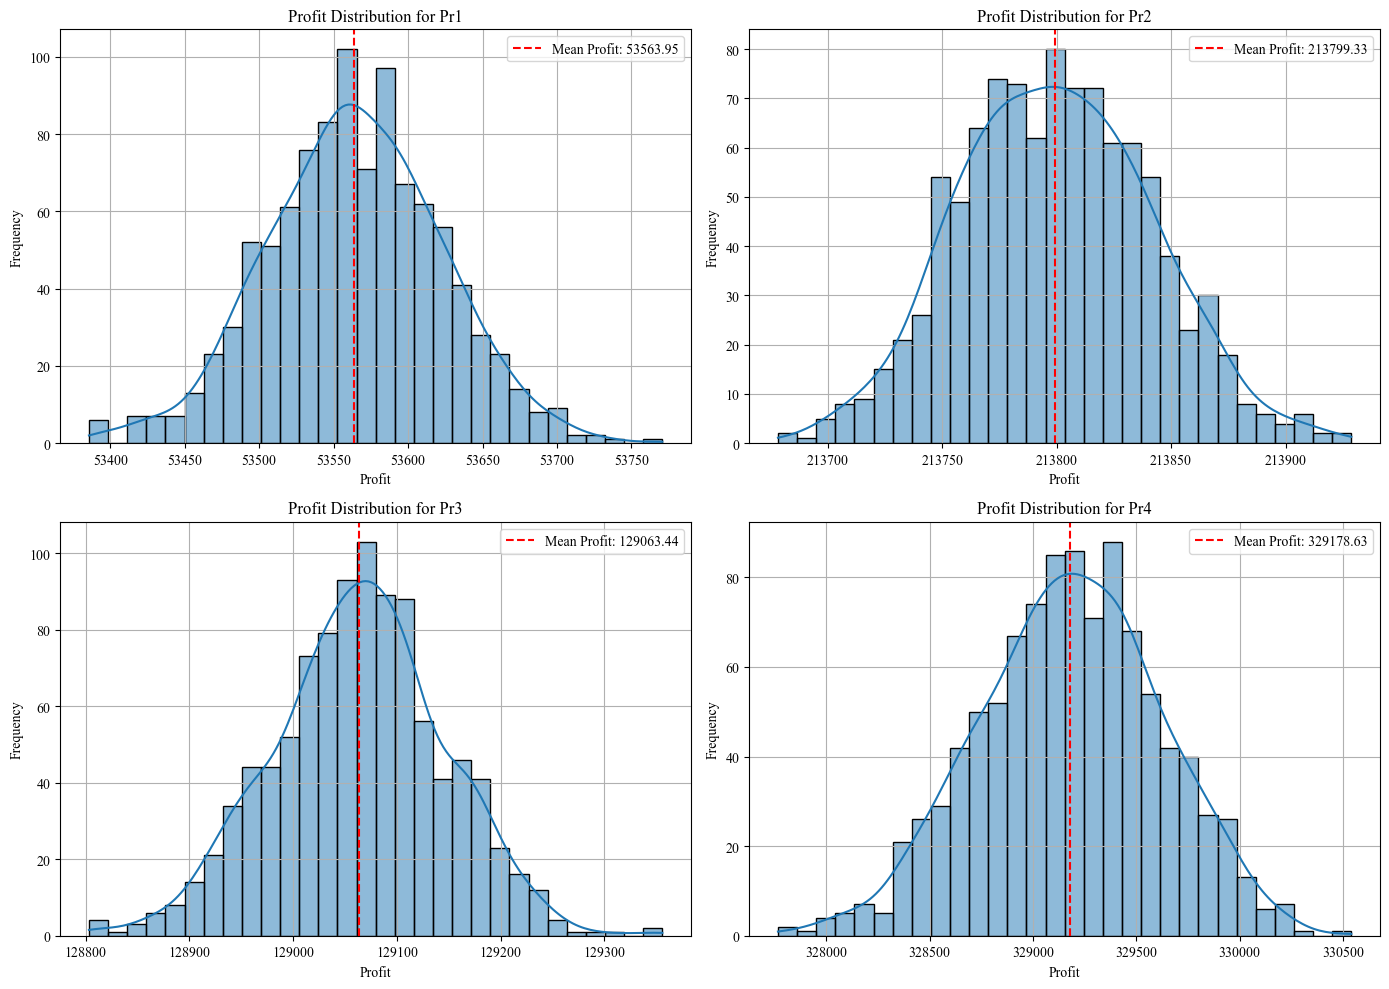

In [81]:
def calculate_safety_stock(max_daily_sales, max_lead_time, avg_daily_sales, avg_lead_time):
    safety_stock = (max_daily_sales * max_lead_time) - (avg_daily_sales * avg_lead_time)
    return safety_stock

# Define summary data
summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Mean Demand (Lead Time)': [103.50, 648.55, 201.68, 150.06],
    'Std. Dev. of Demand (Lead Time)': [37.32, 26.45, 31.08, 3.21],
    'Expected Demand (Lead Time)': [705, 3891, 2266, 785]
}

class Product:
    def __init__(self, i):
        self.mean = np.mean([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.sd = np.std([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.mean_demand_lead_time = summary['Mean Demand (Lead Time)'][i - 1]
        self.std_dev_demand_lead_time = summary['Std. Dev. of Demand (Lead Time)'][i - 1]
        self.expected_demand_lead_time = summary['Expected Demand (Lead Time)'][i - 1]

def daily_demand(mean, sd, probability):
    if np.random.uniform(0, 1) > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS(Q, product, review_period=30, z_score=1.65):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.expected_demand_lead_time  

    
    high_demand_value = 2 * mean  
    weights = [0.8, 0.2]  
    means = [mean, high_demand_value]
    sds = [sd, sd]  

    
    daily_sales = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), size=365, p=weights)]  
    max_daily_sales = np.max(daily_sales)
    avg_daily_sales = np.mean(daily_sales)

    
    max_lead_time = lead_time
    avg_lead_time = np.mean(summary['Lead Time'])

    safety_stock = calculate_safety_stock(max_daily_sales, max_lead_time, avg_daily_sales, avg_lead_time)

    
    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': [], 
            'reorder_quantities': []}  

    for day in range(1, 365):
        
        day_demand = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), 
                                                                                   size=365, p=weights)]  
        if day_demand != 0:  
            data['daily_demand'].append(day_demand)

        if day % review_period == 0:

            q = max(0, safety_stock + demand_lead - inventory)
            q = max(q, int(0.2 * mean))  
            order_placed = True
            data['orders'].append(q)
            data['reorder_quantities'].append(q)  

        if order_placed:
            counter += 1

        if counter == lead_time:
            inventory += q
            order_placed = False
            counter = 0

        for demand in day_demand:  
            if inventory - demand >= 0:
                data['units_sold'].append(demand)
                inventory -= demand
            else:
                data['units_sold'].append(inventory)
                data['units_lost'].append(demand - inventory)
                inventory = 0
                stock_out += 1

            data['inv_level'].append(inventory)

    return data

def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size / days
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

# Simulation and plotting
products = [Product(i) for i in range(1, 5)]
results = {}

for product in products:
    profit_list = []
    reorder_quantity_list = []
    for _ in range(1000):  
        data = MCS(Q=10000, product=product)
        profit = profit_calculation(data, product)
        profit_list.append(profit)
        reorder_quantity_list.extend(data['reorder_quantities'])  
    results[f'Pr{product.i}'] = {
        'profit_list': profit_list,
        'reorder_quantity_list': reorder_quantity_list
    }

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (product_name, result) in enumerate(results.items()):
    profit_list = result['profit_list']
    reorder_quantity_list = result['reorder_quantity_list']

    ax = axes[idx // 2, idx % 2]
    sns.histplot(profit_list, kde=True, bins=30, ax=ax)
    ax.set_title(f'Profit Distribution for {product_name}')
    ax.set_xlabel('Profit')
    ax.set_ylabel('Frequency')

    # Calculate mean of profit distribution
    mean_profit = np.mean(profit_list)
    ax.axvline(mean_profit, color='r', linestyle='--', label=f'Mean Profit: {mean_profit:.2f}')
    ax.legend()

print("Reorder Quantities:")
for product_name, data in results.items():
    reorder_quantity_list = data['reorder_quantity_list']
    print(f"{product_name}: Mean Reorder Quantity = {np.mean(reorder_quantity_list):.2f}, "
          f"Std. Dev. of Reorder Quantity = {np.std(reorder_quantity_list):.2f}")

plt.tight_layout()
plt.show()

## Profit distribution 
### safety_stock = (mean_demand + std_dev * z_score) * lead_time

C:\Users\sarit.maitra\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarit.maitra\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarit.maitra\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarit.maitra\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

Reorder Quantities:
Pr1: Mean Reorder Quantity = 746.76, Std. Dev. of Reorder Quantity = 0.00
Pr2: Mean Reorder Quantity = 3929.85, Std. Dev. of Reorder Quantity = 0.00
Pr3: Mean Reorder Quantity = 2345.60, Std. Dev. of Reorder Quantity = 0.00
Pr4: Mean Reorder Quantity = 845.13, Std. Dev. of Reorder Quantity = 0.00


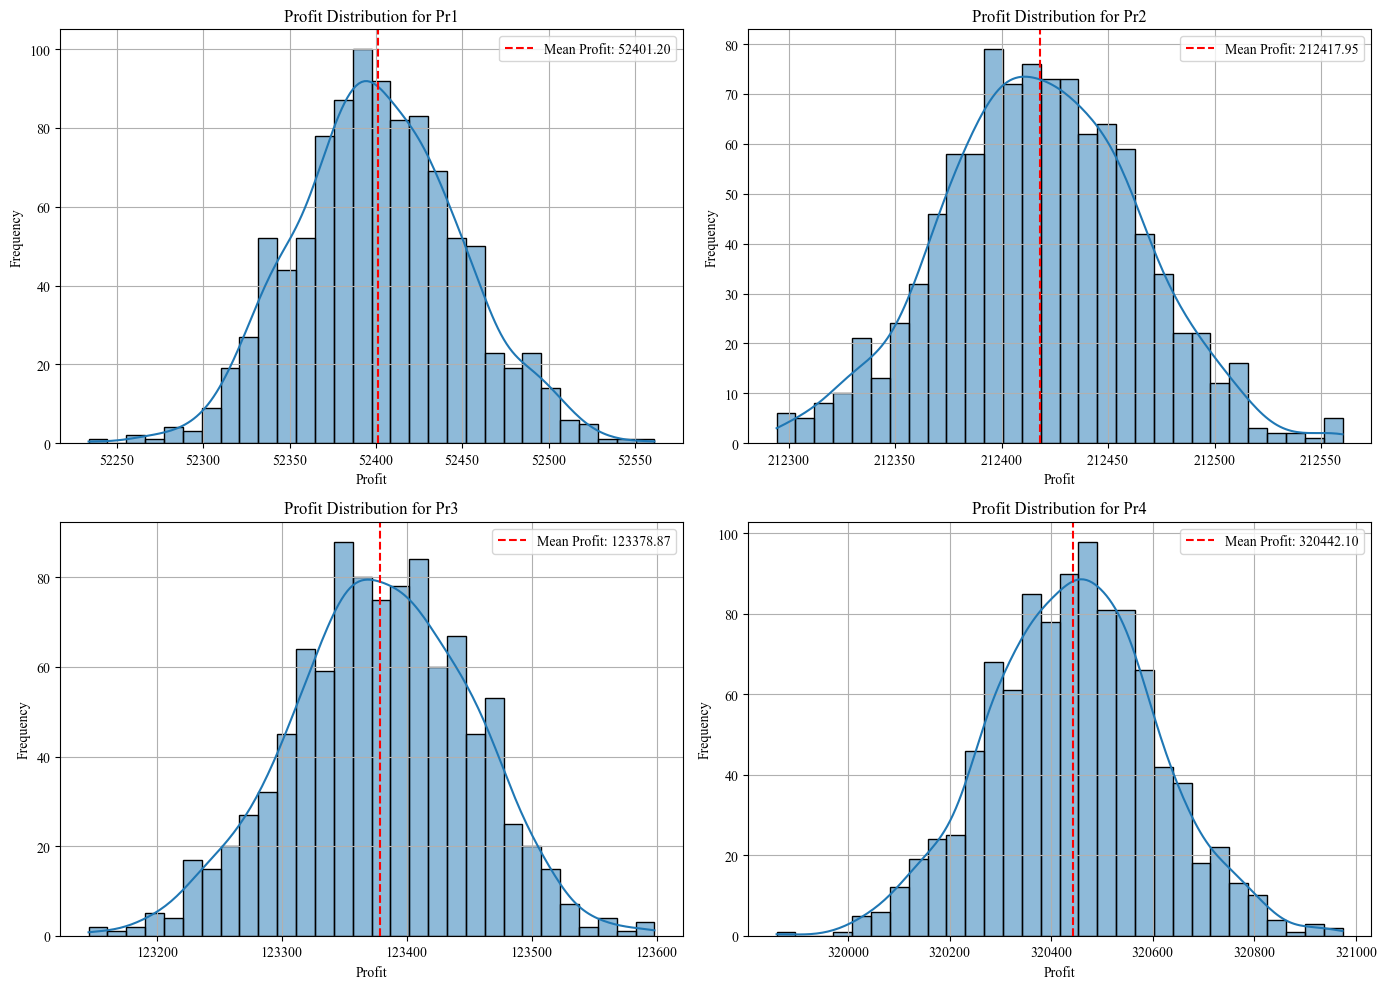

In [91]:
def calculate_safety_stock(mean_demand, std_dev, z_score, lead_time):
    safety_stock = (mean_demand + std_dev * z_score) * lead_time
    return safety_stock

# Define summary data
summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Mean Demand (Lead Time)': [103.50, 648.55, 201.68, 150.06],
    'Std. Dev. of Demand (Lead Time)': [37.32, 26.45, 31.08, 3.21],
    'Demand_lead': [705, 3891, 2266, 785],
    
}

class Product:
    def __init__(self, i):
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.demand_lead = summary['Demand_lead'][i - 1]

        demand_data = [np.log(j) for j in demand[f'Pr{i}'] if j > 0]
        self.mean = np.mean(demand_data)
        self.std_dev = np.std(demand_data)

def daily_demand(mean, sd, probability):
    if np.random.uniform(0, 1) > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS(Q, product, review_period=30, z_score=1.65):
    inventory = product.starting_stock
    mean_demand = product.mean
    std_dev = product.std_dev
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.demand_lead
    

    
    high_demand_value = 2 * mean_demand  
    weights = [0.8, 0.2]  
    means = [mean_demand, high_demand_value]
    sds = [std_dev, std_dev]  

    
    daily_sales = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), size=365, p=weights)]  
    max_daily_sales = np.max(daily_sales)
    avg_daily_sales = np.mean(daily_sales)

    
    max_lead_time = lead_time
    avg_lead_time = np.mean(summary['Lead Time'])

    
    safety_stock = calculate_safety_stock(mean_demand, std_dev, z_score, lead_time)

    
    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': [], 'reorder_quantities': []}  # Added 'reorder_quantities'

    for day in range(1, 365):
        
        day_demand = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), size=365, p=weights)]  # Corrected list comprehension
        if day_demand != 0:  
            data['daily_demand'].append(day_demand)

        if day % review_period == 0:

            q = max(0, safety_stock + demand_lead - inventory)
            q = max(q, int(0.2 * mean_demand))  
            order_placed = True
            data['orders'].append(q)
            data['reorder_quantities'].append(q)  

        if order_placed:
            counter += 1

        if counter == lead_time:
            inventory += q
            order_placed = False
            counter = 0

        for demand in day_demand:  
            if inventory - demand >= 0:
                data['units_sold'].append(demand)
                inventory -= demand
            else:
                data['units_sold'].append(inventory)
                data['units_lost'].append(demand - inventory)
                inventory = 0
                stock_out += 1

            data['inv_level'].append(inventory)

    return data

def calculate_profit(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size / days
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit


products = [Product(i) for i in range(1, 5)]
results = {}

for product in products:
    profit_list = []
    reorder_quantity_list = []
    for _ in range(1000):  
        data = MCS(Q=10000, product=product)
        profit = calculate_profit(data, product)
        profit_list.append(profit)
        reorder_quantity_list.extend(data['reorder_quantities'])  
    results[f'Pr{product.i}'] = {
        'profit_list': profit_list,
        'reorder_quantity_list': reorder_quantity_list
    }

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (product_name, result) in enumerate(results.items()):
    profit_list = result['profit_list']
    reorder_quantity_list = result['reorder_quantity_list']

    ax = axes[idx // 2, idx % 2]
    sns.histplot(profit_list, kde=True, bins=30, ax=ax)
    ax.set_title(f'Profit Distribution for {product_name}')
    ax.set_xlabel('Profit')
    ax.set_ylabel('Frequency')

    
    mean_profit = np.mean(profit_list)
    ax.axvline(mean_profit, color='r', linestyle='--', label=f'Mean Profit: {mean_profit:.2f}')
    ax.legend()

print("Reorder Quantities:")
for product_name, data in results.items():
    reorder_quantity_list = data['reorder_quantity_list']
    print(f"{product_name}: Mean Reorder Quantity = {np.mean(reorder_quantity_list):.2f}, "
          f"Std. Dev. of Reorder Quantity = {np.std(reorder_quantity_list):.2f}")

plt.tight_layout()
plt.show()